# Spin Hall conductivity

author: Jae-Mo Lihm (jaemo.lihm@gmail.com) and Minsu Ghim (minsu.ghim.physics@gmail.com)

In this tutorial, we calculate the spin Berry curvature and the spin Hall conductivity of bcc Platinum. We compare the two methods for calculating the spin velocity matrix, which we call the "Qiao" method [1] and the "Ryoo" method [2].

[1] [J. Qiao et al, Phys. Rev. B 98, 214402 (2018)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.98.214402) <br>
[2] [J. H. Ryoo et al, Phys. Rev. B 99, 235113 (2019)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.235113)

Both methods use the Kubo formula to calculate spin Hall conductivity under time-reversal symmetry:

\begin{equation}
\sigma^{{\rm SHC}, \gamma}_{\alpha\beta} = \frac{-e\hbar}{N_k V_c}\sum_{\bf k}\sum_{n,m}\left(f_{n{\bf k}}-f_{m{\bf k}}\right)\frac{\textrm{Im}\left[\langle\psi_{n{\bf k}}\vert \frac{1}{2}\{ s^{\gamma}, v_\alpha \} \vert\psi_{m{\bf k}}\rangle\langle\psi_{m{\bf k}}\vert v_\beta\vert\psi_{n{\bf k}}\rangle\right]}{(\varepsilon_{n{\bf k}}-\varepsilon_{m{\bf k}})^2-(\hbar\omega+i\eta)^2}\,,
\label{eq:shc}\tag{1}
\end{equation}

where $\alpha$, $\beta$, $\gamma$ are respectively the direction of spin current, applied electric field, and spin polarisation.

The "Ryoo" method requires `.chk`, `.eig`, `.mmn`, `.spn`, `.sHu`, and `.sIu` files to calculate the spin velocity matrix in (\ref{eq:shc}), $\langle\psi_{n{\bf k}}\vert \frac{1}{2}\{ s^{\gamma}, v_\alpha \} \vert\psi_{m{\bf k}}\rangle$,from pw2wannier90.x,
while the "Qiao" method does not use the last two files, and instead applies an approximation $\mathbf{1}=\sum_{l\in \it{ab\,initio}} \vert u_{l{\bf q}}\rangle\langle u_{l{\bf q}}\vert$.
The `sHu` and `sIu` files are calculated by setting `write_sHu = .true.` and `write_sIu = .true.` to the `pw2wannier90.x` input file: see `data_Pt/pw2wan.in`.

In [1]:
# Preliminary (Do only once)
%load_ext autoreload
%autoreload 2

# Set environment variables - not mandatory but recommended
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' 
os.environ['MKL_NUM_THREADS'] = '1'


import wannierberri as wberri
import numpy as np
import scipy
import matplotlib.pyplot as plt

#  This block is needed if you run this cell for a second time
#  because one cannot initiate two parallel environments at a time
try:
    parallel.shutdown()   
except NameError:
    pass

parallel = wberri.Parallel(num_cpus=4, progress_step_percent=10)

2022-09-05 15:27:01,359	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


### Model, band structure

We load the system from a Wannier90 output. Note the arguments `SHCryoo=True` and `SHCqiao=True` which are required to compute spin Hall conductivity using the Ryoo and Qiao methods, respectively.

We set symmetry using the `set_symmetry_from_structure` method, which calls spglib to automatically determine the symmetry of the system.

<!-- We also symmetrize the system. See `data_Pt/Pt.win` file and check that the initial projections are correct. For details, refer to the symmetrization tutorial. -->

In [2]:
system = wberri.System_w90("data_Pt/Pt", berry=True, SHCryoo=True, SHCqiao=True)
system.set_structure([[0., 0., 0.]], ["Pt"])
system.set_symmetry_from_structure()

efermi = 18.1605

using fortio to read
Reading restart information from file data_Pt/Pt.chk :
Time to read .chk : 0.16887259483337402


Time for MMN.__init__() : 0.5381078720092773 , read : 0.5264289379119873 , headstring 0.011678934097290039
----------
 SPN  
---------

using fortio to read
reading data_Pt/Pt.spn : Created on 13May2022 at 15:23:23                            
----------
 SPN OK  
---------



----------
  sIu   
---------
using fortio to read
reading data_Pt/Pt.sIu : <Created on 13May2022 at 15:23:23>


----------
 sIu OK  
---------

----------
  sHu   
---------
using fortio to read
reading data_Pt/Pt.sHu : <Created on 13May2022 at 15:23:23>


----------
 sHu OK  
---------

time for FFT_q_to_R : 1.0874583721160889 s
using ws_distance


irvec_new_all shape (93,)
using ws_dist for Ham_R
using ws_dist for AA_R
using ws_dist for SS_R
using ws_dist for SA_R
using ws_dist for SHA_R
using ws_dist for SR_R


using ws_dist for SH_R
using ws_dist for SHR_R
Number of wannier functions: 18
Number of R points: 93
Recommended size of FFT grid [4 4 4]
Real-space lattice:
 [[-1.95599772  0.          1.95599772]
 [ 0.          1.95599772  1.95599772]
 [-1.95599772  1.95599772  0.        ]]


In [3]:
path = wberri.Path(
    system,
    k_nodes=[
        [0.25, 0.75, 0.50], # W
        [0.50, 0.50, 0.50], # L
        [0.00, 0.00, 0.00], # Gamma
        [0.50, 0.00, 0.50], # X
        [0.50, 0.25, 0.75], # W
        [0.00, 0.00, 0.00], # Gamma
    ],
    labels=["W", "L", "$\Gamma$", "X", "W", "$\Gamma$"],
    length=300,
)

from wannierberri import calculators as calc
calculators = {}
calculators["tabulate"] = calc.TabulatorAll(
    {"Energy": calc.tabulate.Energy()},
    ibands=np.arange(system.num_wann),
    mode="path",
)

path_result = wberri.run(
    system,
    grid=path,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
)

calculator not described

Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.TabulatorAll object at 0x7fea242890a0>
All calculators are compatible
Symmetrization switched off for Path
The set of k points is a Path() with 322 points and labels {0: 'W', 54: 'L', 120: '$\\Gamma$', 197: 'X', 235: 'W', 321: '$\\Gamma$'}
generating K_list
Done 
Done, sum of weights:322.0
symgroup : None


processing 322 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)


                  32              4.1                  36.7


                  64              4.5                  18.0


                  96              4.8                  11.4


                 128              5.3                   8.0


                 160              5.7                   5.7


                 192              6.1                   4.1


                 224              6.5                   2.8


                 256              6.9                   1.8


                 288              7.3                   0.9


                 320              7.7                   0.0


time for processing    322 K-points on   4 processes:     7.7343 ; per K-point          0.0240 ; proc-sec per K-point          0.0961


time1 =  0.020120620727539062
Totally processed 322 K-points 


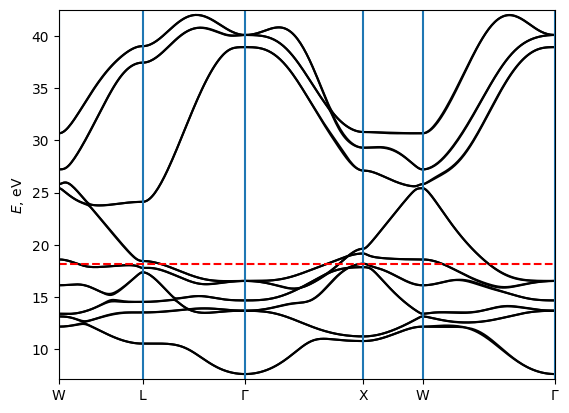

In [4]:
fig = path_result.results["tabulate"].plot_path_fat(path, close_fig=False, show_fig=False)

ax = fig.get_axes()[0]
ax.axhline(efermi, c="r", ls="--")
plt.show(fig)

## Static spin Hall conductivity

We calculate the static (i.e. DC) spin Hall conductivity. We fix $\omega$ to 0 and scan the Fermi energy.

In [5]:
from wannierberri import calculators as calc

efermi_list = np.linspace(efermi - 1.0, efermi + 1.0, 101, True)

kwargs = dict(
    Efermi=efermi_list,
    omega=np.array([0.]),
    smr_fixed_width = 0.1, # Smearing for frequency in eV
    kBT = 0.026, # Smearing for Fermi level (Fermi-Dirac factor) in eV (not Kelvin)
)

calculators = dict(
    SHC_ryoo = calc.dynamic.SHC(SHC_type="ryoo", **kwargs),
    SHC_qiao = calc.dynamic.SHC(SHC_type="qiao", **kwargs),
)

a more laconic implementation of the energy factor

a more laconic implementation of the energy factor



In [6]:
nk = 30
grid = wberri.Grid(system, NK=nk)
result = wberri.run(
    system,
    grid=grid,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
)

determining grids from NK=30 (<class 'int'>), NKdiv=None (<class 'NoneType'>), NKFFT=None (<class 'NoneType'>)
Minimal symmetric FFT grid :  [4 4 4]
The grids were set to NKdiv=[6 6 6], NKFFT=[5 5 5], NKtot=[30 30 30]
Grid is regular
The set of k points is a Grid() with NKdiv=[6 6 6], NKFFT=[5 5 5], NKtot=[30 30 30]


generating K_list
Done in 0.002763986587524414 s 
excluding symmetry-equivalent K-points from initial grid


Done in 0.11371755599975586 s 
Done in 0.11384940147399902 s 
K_list contains 16 Irreducible points(7.41%) out of initial 6x6x6=216 grid
Done, sum of weights:0.9999999999999997
symgroup : <wannierberri.symmetry.Group object at 0x7fea243f2a90>
processing 16 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)


                   4             17.3                  51.8


                   8             33.1                  33.1


                  12             48.7                  16.2


time for processing     16 K-points on   4 processes:    64.0240 ; per K-point          4.0015 ; proc-sec per K-point         16.0060


time1 =  0.0033326148986816406
Totally processed 16 K-points 


The SHC data has 5 indices:
1. The Fermi level index,
2. The frequency index,
3. The spin current direction index,
4. The electric field direction index, and
5. The spin polarization index.

In [7]:
print("result.results[\"SHC_ryoo\"].data.shape = ", result.results["SHC_ryoo"].data.shape)

result.results["SHC_ryoo"].data.shape =  (101, 1, 3, 3, 3)


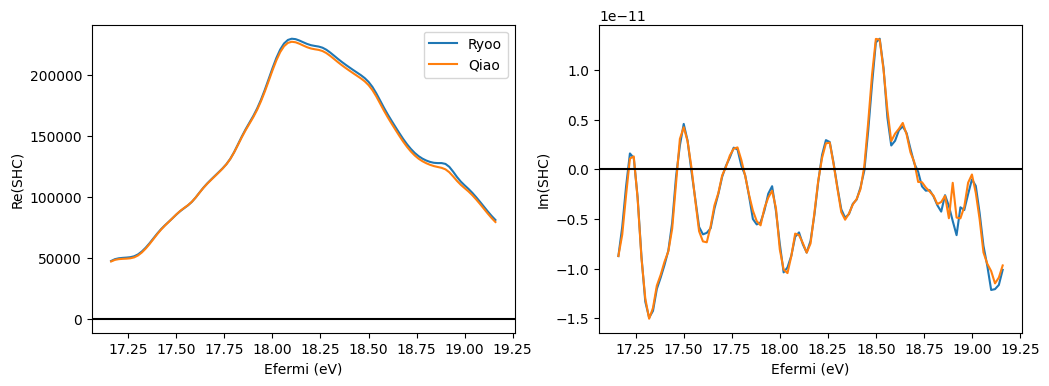

In [8]:
shc_ryoo = result.results["SHC_ryoo"].data[:, 0, 0, 1, 2]
shc_qiao = result.results["SHC_qiao"].data[:, 0, 0, 1, 2]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(efermi_list, shc_ryoo.real, label="Ryoo")
axes[0].plot(efermi_list, shc_qiao.real, label="Qiao")
axes[1].plot(efermi_list, shc_ryoo.imag)
axes[1].plot(efermi_list, shc_qiao.imag)
for ax in axes:
    ax.set_xlabel("Efermi (eV)")
    ax.axhline(0, c="k")
axes[0].set_ylabel("Re(SHC)")
axes[1].set_ylabel("Im(SHC)")
axes[0].legend()
plt.show()

## Dynamic spin Hall conductivity

We calculate the dynamic (i.e. frequency-dependent, AC) spin Hall conductivity. We fix the Fermi energy to the value `efermi` and scan the frequency in the range `omega`.

The `smr_fixed_width` parameter controls the smearing of the frequency-dependent terms (delta functions and principal values).

In [9]:
from wannierberri import calculators as calc

omega = np.linspace(0, 4, 101, True)

kwargs = dict(
    Efermi=np.array([efermi]),
    omega=omega,
    smr_fixed_width = 0.1, # Smearing for frequency in eV
    kBT = 0.026, # Smearing for Fermi level (Fermi-Dirac factor)
)

calculators = dict(
    SHC_ryoo = calc.dynamic.SHC(SHC_type="ryoo", **kwargs),
    SHC_qiao = calc.dynamic.SHC(SHC_type="qiao", **kwargs),
)

a more laconic implementation of the energy factor

a more laconic implementation of the energy factor



In [10]:
nk = 30
grid = wberri.Grid(system, NK=nk)
result = wberri.run(
    system,
    grid=grid,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
)

determining grids from NK=30 (<class 'int'>), NKdiv=None (<class 'NoneType'>), NKFFT=None (<class 'NoneType'>)
Minimal symmetric FFT grid :  [4 4 4]
The grids were set to NKdiv=[6 6 6], NKFFT=[5 5 5], NKtot=[30 30 30]
Grid is regular
The set of k points is a Grid() with NKdiv=[6 6 6], NKFFT=[5 5 5], NKtot=[30 30 30]


generating K_list
Done in 0.003281116485595703 s 
excluding symmetry-equivalent K-points from initial grid


Done in 0.11312651634216309 s 
Done in 0.11327314376831055 s 
K_list contains 16 Irreducible points(7.41%) out of initial 6x6x6=216 grid
Done, sum of weights:0.9999999999999997
symgroup : <wannierberri.symmetry.Group object at 0x7fea243f2a90>
processing 16 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)


                   4             13.8                  41.5


                   8             26.2                  26.2


                  12             38.0                  12.7


time for processing     16 K-points on   4 processes:    49.0079 ; per K-point          3.0630 ; proc-sec per K-point         12.2520


time1 =  0.0037038326263427734
Totally processed 16 K-points 


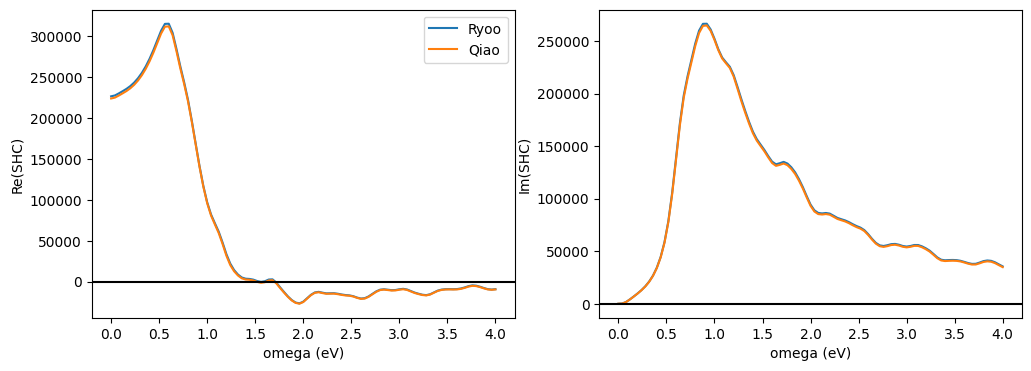

In [11]:
shc_ryoo = result.results["SHC_ryoo"].data[0, :, 0, 1, 2]
shc_qiao = result.results["SHC_qiao"].data[0, :, 0, 1, 2]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(omega, shc_ryoo.real, label="Ryoo")
axes[0].plot(omega, shc_qiao.real, label="Qiao")
axes[1].plot(omega, shc_ryoo.imag)
axes[1].plot(omega, shc_qiao.imag)
for ax in axes:
    ax.set_xlabel("omega (eV)")
    ax.axhline(0, c="k")
axes[0].set_ylabel("Re(SHC)")
axes[1].set_ylabel("Im(SHC)")
axes[0].legend()
plt.show()

## Spin Berry curvature

To understand the microscopic origin of the spin Hall conductivity, one may inspect the k-resolved spin Berry curvature.
Eq. (\ref{eq:shc}) is recast into the sum of a Berry-curvature-like term, the spin Berry curvature.

The spin Berry curvature is

\begin{equation}
  \Omega^{n, \gamma}_{\alpha\beta}({\bf k}) = -\sum_{m \neq n}\frac{2\textrm{Im}\left[\langle\psi_{n{\bf k}}\vert \frac{1}{2}\{ s^{\gamma}, v_\alpha \} \vert\psi_{m{\bf k}}\rangle\langle\psi_{m{\bf k}}\vert v_\beta\vert\psi_{n{\bf k}}\rangle\right]}{(\varepsilon_{n{\bf k}}-\varepsilon_{m{\bf k}})^2-(i\eta)^2}\,,
  \label{eq:sbc}\tag{2}
\end{equation}

and the k-resolved spin Berry curvature summed over the band index is

\begin{equation}
  \Omega^{\gamma}_{\alpha\beta}({\bf k}) = \sum_{n}f_{n{\bf k}}\Omega^{n, \gamma}_{\alpha\beta}({\bf k})\,.
  \label{eq:sbc_k_resolved}\tag{3}
\end{equation}
\begin{equation}
  \sigma^{{\rm SHC}, \gamma}_{\alpha\beta} = \frac{-e\hbar}{N_k\Omega_c}\sum_{\bf k}\Omega^{\gamma}_{\alpha\beta}({\bf k})
  \label{eq:shc_sbc}\tag{4}
\end{equation}

Therefore, where in the k-space contributes to the total SHC can be investigated using the k-resolved spin Berry curvature.

Here, we compute the spin Berry curvature again using the Ryoo method and the Qiao method.
Note that we pass the spin curren type as a `kwargs_formula` to the calculator, e.g. `kwargs_formula=dict(spin_current_type="ryoo")`.

In [12]:
from wannierberri import calculators as calc
calculators = {}
calculators["tabulate"] = calc.TabulatorAll(
     {
         "Energy": calc.tabulate.Energy(),
         'spin_berry_ryoo': calc.tabulate.SpinBerry(kwargs_formula=dict(spin_current_type="ryoo"), degen_thresh=1e-2),
         'spin_berry_qiao': calc.tabulate.SpinBerry(kwargs_formula=dict(spin_current_type="qiao"), degen_thresh=1e-2),
     },
    ibands=np.arange(system.num_wann),
    mode="path",
 )

calculator not described

calculator not described

calculator not described



In [13]:
path = wberri.Path(
    system,
    k_nodes=[
        [0.25, 0.75, 0.50], # W
        [0.50, 0.50, 0.50], # L
        [0.00, 0.00, 0.00], # Gamma
        [0.50, 0.00, 0.50], # X
        [0.50, 0.25, 0.75], # W
        [0.00, 0.00, 0.00], # Gamma
    ],
    labels=["W", "L", "$\Gamma$", "X", "W", "$\Gamma$"],
    length=600,
)

result_spin_berry = wberri.run(
    system,
    grid=path,
    calculators=calculators,
    parallel = parallel,
    print_Kpoints = False,
)

Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.TabulatorAll object at 0x7fea2406d970>
All calculators are compatible
Symmetrization switched off for Path
The set of k points is a Path() with 643 points and labels {0: 'W', 108: 'L', 241: '$\\Gamma$', 394: 'X', 471: 'W', 642: '$\\Gamma$'}
generating K_list
Done 
Done, sum of weights:643.0
symgroup : None


processing 643 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)


                  64              2.5                  22.4


                 128              4.2                  16.9


                 192              5.9                  13.9


                 256              7.8                  11.8


                 320              9.7                   9.8


                 384             11.4                   7.7


                 448             13.2                   5.7


                 512             14.9                   3.8


                 576             16.8                   2.0


                 640             18.6                   0.1


time for processing    643 K-points on   4 processes:    18.7099 ; per K-point          0.0291 ; proc-sec per K-point          0.1164


time1 =  0.16102385520935059
Totally processed 643 K-points 


Now we sum over bands to compute the k-resolved spin Berry curvature:
$$\Omega^{\gamma}_{\alpha\beta}({\bf k}) = \sum_{n \in {\rm occ.}} \Omega^{n, \gamma}_{\alpha\beta}({\bf k})$$

In [14]:
nk = path.K_list.shape[0]
spin_berry_ryoo = np.zeros((nk, 3, 3, 3))
spin_berry_qiao = np.zeros((nk, 3, 3, 3))

for iband in range(system.num_wann):
    # Get the data for iband-th band
    e = result_spin_berry.results["tabulate"].get_data("Energy", iband)
    spin_berry_ryoo_nk = result_spin_berry.results["tabulate"].get_data("spin_berry_ryoo", iband)
    spin_berry_qiao_nk = result_spin_berry.results["tabulate"].get_data("spin_berry_qiao", iband)

    # Select k-point indices where the iband-th band is occupied
    inds_occupied = e < efermi
    
    # Add the spin Berry curvature of those bands
    spin_berry_ryoo[inds_occupied] += spin_berry_ryoo_nk[inds_occupied]
    spin_berry_qiao[inds_occupied] += spin_berry_qiao_nk[inds_occupied]

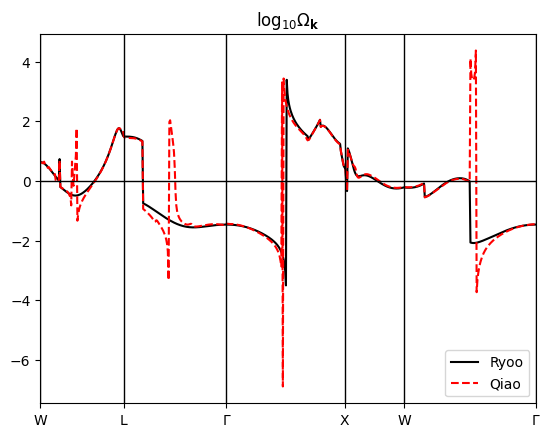

In [15]:
def get_signed_log10(x):
    return np.log10(abs(x)) * np.sign(x)
    
kline = path.getKline()
plt.plot(kline, get_signed_log10(spin_berry_ryoo[:, 0, 1, 2]), "k-", label='Ryoo')
plt.plot(kline, get_signed_log10(spin_berry_qiao[:, 0, 1, 2]), "r--", label='Qiao')

for i in path.labels.keys():
    plt.axvline(kline[i], c="k", lw=1)
plt.xticks([kline[i] for i in path.labels.keys()], path.labels.values())
plt.xlim([min(kline), max(kline)])
plt.axhline(0, c="k", lw=1)
plt.legend()
plt.title("$\mathrm{log}_{10} \Omega_\mathbf{k}$")

plt.show()

You can find that the spin Berry curvature calculated using the Qiao method shows more "wiggles" than the Ryoo method. This numerical difference has been first reported in [T. Ng et al, PRB 104 014412 (2021)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.104.014412):

>  It is worth
noting that there is jittering along Γ-Z, which occurs in the same path in WTe2 using the same method [22] (Qiao et al). However, such jittering disappears and the spin Berry curvature along Γ-Z becomes a smooth function using the method in Ref. [45] (Ryoo et al).

## Generating .sHu and .sIu from .mmn and .spn: mmn2uHu 

Even if you have not obtained .shu and .sIu from an ab initio code, you can make them from the overlap matrix and the spin matrix. Wannierberri provides the utility `wannierberri.utils.mmn2uHu`, which calculated the matrices `.uHu`, `.uIu`, `.sHu`, and/or `.sIu` from the `.mmn`, `.spn`, `.eig` matrices, and also reduces the number of bands in `.amn`, `.mmn`, `.eig`  and `.spn` files, by means of the sum-over-states formula

\begin{equation}
  \langle u_{m{\bf q}}\vert\hat{s}\hat{H}_{\bf q}\vert u_{n{\bf q}+\mathbf{b}}\rangle \approx \sum_l^{l_{\rm max}}  \left(s_{lm}({\bf q})\right)^* E_{l{\bf q}}   M_{ln}^{\mathbf{b}}({\bf q})\,.
\label{eq:sHu}\tag{5}
\end{equation}

\begin{equation}
  \langle u_{m{\bf q}}\vert\hat{s}\vert u_{n{\bf q}+\mathbf{b}}\rangle \approx \sum_l^{l_{\rm max}}  \left(s_{lm}({\bf q})\right)^*   M_{ln}^{\mathbf{b}}({\bf q})\,.
\label{eq:sIu}\tag{6}
\end{equation}

Here, $l_{\rm max}$ cannot exceed the number of bands included in the Wannier90 calculation (i.e. the `num_bands` parameter in `Pt.win`).

The `mmn2uHu` utility can be particularly useful when the calculation of `sHu` and `sIu` files are not implemented in the DFT code you are using.

In [16]:
from wannierberri.utils import mmn2uHu as mmn2uHu
os.chdir("data_Pt")
mmn2uHu.run_mmn2uHu(PREFIX="Pt", writeSHU=True, writeSIU=True, NBout=18, NBsum=24)

# For a command-line execution of the mmn2uHu utility, use
# python3 -m wannierberri.utils.mmn2uHu Pt NBout=18,NBsum=24,targets=sHu,sIu

# Rename sHu and sIu files
import shutil
shutil.move("reduced_NB=24/Pt_nbs=24.sHu", "reduced_NB=24/Pt.sHu")
shutil.move("reduced_NB=24/Pt_nbs=24.sIu", "reduced_NB=24/Pt.sIu")

# Copy chk and spn files
shutil.copyfile("Pt.chk", "reduced_NB=24/Pt.chk")
shutil.copyfile("Pt.spn", "reduced_NB=24/Pt.spn")

os.chdir("..")

----------
 MMN  read
---------

k-point 1 of 64
k-point 2 of 64
k-point 3 of 64
k-point 4 of 64
k-point 5 of 64
k-point 6 of 64
k-point 7 of 64
k-point 8 of 64
k-point 9 of 64
k-point 10 of 64
k-point 11 of 64
k-point 12 of 64
k-point 13 of 64
k-point 14 of 64
k-point 15 of 64
k-point 16 of 64
k-point 17 of 64
k-point 18 of 64
k-point 19 of 64
k-point 20 of 64
k-point 21 of 64
k-point 22 of 64
k-point 23 of 64
k-point 24 of 64
k-point 25 of 64
k-point 26 of 64
k-point 27 of 64
k-point 28 of 64
k-point 29 of 64
k-point 30 of 64
k-point 31 of 64


k-point 32 of 64
k-point 33 of 64
k-point 34 of 64
k-point 35 of 64
k-point 36 of 64
k-point 37 of 64
k-point 38 of 64
k-point 39 of 64
k-point 40 of 64
k-point 41 of 64
k-point 42 of 64
k-point 43 of 64
k-point 44 of 64
k-point 45 of 64
k-point 46 of 64
k-point 47 of 64
k-point 48 of 64
k-point 49 of 64
k-point 50 of 64
k-point 51 of 64
k-point 52 of 64
k-point 53 of 64
k-point 54 of 64
k-point 55 of 64
k-point 56 of 64
k-point 57 of 64
k-point 58 of 64
k-point 59 of 64
k-point 60 of 64
k-point 61 of 64


k-point 62 of 64
k-point 63 of 64
k-point 64 of 64
----------
 MMN  read - OK
---------

[Errno 17] File exists: 'reduced_NB=24'
k-point 0 of 64
k-point 1 of 64
k-point 2 of 64
k-point 3 of 64
k-point 4 of 64
k-point 5 of 64
k-point 6 of 64
k-point 7 of 64
k-point 8 of 64
k-point 9 of 64
k-point 10 of 64
k-point 11 of 64


k-point 12 of 64
k-point 13 of 64
k-point 14 of 64
k-point 15 of 64
k-point 16 of 64
k-point 17 of 64
k-point 18 of 64
k-point 19 of 64
k-point 20 of 64
k-point 21 of 64
k-point 22 of 64
k-point 23 of 64
k-point 24 of 64


k-point 25 of 64
k-point 26 of 64
k-point 27 of 64
k-point 28 of 64
k-point 29 of 64
k-point 30 of 64
k-point 31 of 64
k-point 32 of 64
k-point 33 of 64
k-point 34 of 64
k-point 35 of 64
k-point 36 of 64
k-point 37 of 64


k-point 38 of 64
k-point 39 of 64
k-point 40 of 64
k-point 41 of 64
k-point 42 of 64
k-point 43 of 64
k-point 44 of 64
k-point 45 of 64
k-point 46 of 64
k-point 47 of 64
k-point 48 of 64
k-point 49 of 64
k-point 50 of 64


k-point 51 of 64
k-point 52 of 64
k-point 53 of 64
k-point 54 of 64
k-point 55 of 64
k-point 56 of 64
k-point 57 of 64
k-point 58 of 64
k-point 59 of 64
k-point 60 of 64
k-point 61 of 64
k-point 62 of 64
k-point 63 of 64


----------
 MMN OK  
---------

----------
 AMN   
---------

AMN size= (27648, 2)
24 18 64


----------
 AMN  - OK 
---------

[('uHu', False)]
----------
  uHu  NBsum=24 
---------
uHu from mmn red to 24 sum 24 bnd 2022-09-05T15:29:40.240483
60
using scipy.io to write
k-point 1 of 64
k-point 2 of 64
k-point 3 of 64
k-point 4 of 64
k-point 5 of 64
k-point 6 of 64
k-point 7 of 64
k-point 8 of 64
k-point 9 of 64
k-point 10 of 64
k-point 11 of 64
k-point 12 of 64
k-point 13 of 64
k-point 14 of 64
k-point 15 of 64
k-point 16 of 64
k-point 17 of 64
k-point 18 of 64
k-point 19 of 64
k-point 20 of 64


k-point 21 of 64
k-point 22 of 64
k-point 23 of 64
k-point 24 of 64
k-point 25 of 64
k-point 26 of 64
k-point 27 of 64
k-point 28 of 64
k-point 29 of 64
k-point 30 of 64
k-point 31 of 64
k-point 32 of 64
k-point 33 of 64
k-point 34 of 64
k-point 35 of 64
k-point 36 of 64
k-point 37 of 64
k-point 38 of 64
k-point 39 of 64
k-point 40 of 64


k-point 41 of 64
k-point 42 of 64
k-point 43 of 64
k-point 44 of 64
k-point 45 of 64
k-point 46 of 64
k-point 47 of 64
k-point 48 of 64
k-point 49 of 64
k-point 50 of 64
k-point 51 of 64
k-point 52 of 64
k-point 53 of 64
k-point 54 of 64
k-point 55 of 64
k-point 56 of 64
k-point 57 of 64
k-point 58 of 64
k-point 59 of 64
k-point 60 of 64
k-point 61 of 64


k-point 62 of 64
k-point 63 of 64
k-point 64 of 64
----------
 uHu OK  
---------

----------
 SPN  
---------

using fortio to read
Created on 13May2022 at 15:23:23                            
using scipy.io to write
----------
 SPN OK  
---------

[('sHu', False), ('sIu', False)]
----------
  sHu  NBsum=24 
---------
sHu from mmn red to 24 sum 24 bnd 2022-09-05T15:29:40.926152
60
using scipy.io to write
k-point 1 of 64
k-point 2 of 64
k-point 3 of 64
k-point 4 of 64
k-point 5 of 64
k-point 6 of 64
k-point 7 of 64
k-point 8 of 64
k-point 9 of 64
k-point 10 of 64
k-point 11 of 64
k-point 12 of 64
k-point 13 of 64
k-point 14 of 64
k-point 15 of 64
k-point 16 of 64
k-point 17 of 64
k-point 18 of 64
k-point 19 of 64
k-point 20 of 64
k-point 21 of 64
k-point 22 of 64
k-point 23 of 64
k-point 24 of 64
k-point 25 of 64
k-point 26 of 64
k-point 27 of 64
k-point 28 of 64
k-point 29 of 64


k-point 30 of 64
k-point 31 of 64
k-point 32 of 64
k-point 33 of 64
k-point 34 of 64
k-point 35 of 64
k-point 36 of 64
k-point 37 of 64
k-point 38 of 64
k-point 39 of 64
k-point 40 of 64
k-point 41 of 64
k-point 42 of 64
k-point 43 of 64
k-point 44 of 64
k-point 45 of 64
k-point 46 of 64
k-point 47 of 64
k-point 48 of 64
k-point 49 of 64
k-point 50 of 64
k-point 51 of 64
k-point 52 of 64
k-point 53 of 64
k-point 54 of 64
k-point 55 of 64
k-point 56 of 64
k-point 57 of 64
k-point 58 of 64
k-point 59 of 64
k-point 60 of 64
k-point 61 of 64
k-point 62 of 64
k-point 63 of 64
k-point 64 of 64
----------
 sHu OK  
---------

----------
  sIu  NBsum=24 
---------
sIu from mmn red to 24 sum 24 bnd 2022-09-05T15:29:41.245190
60
using scipy.io to write
k-point 1 of 64
k-point 2 of 64
k-point 3 of 64
k-point 4 of 64
k-point 5 of 64
k-point 6 of 64


k-point 7 of 64
k-point 8 of 64
k-point 9 of 64
k-point 10 of 64
k-point 11 of 64
k-point 12 of 64
k-point 13 of 64
k-point 14 of 64
k-point 15 of 64
k-point 16 of 64
k-point 17 of 64
k-point 18 of 64
k-point 19 of 64
k-point 20 of 64
k-point 21 of 64
k-point 22 of 64
k-point 23 of 64
k-point 24 of 64
k-point 25 of 64
k-point 26 of 64
k-point 27 of 64
k-point 28 of 64
k-point 29 of 64
k-point 30 of 64
k-point 31 of 64
k-point 32 of 64
k-point 33 of 64
k-point 34 of 64
k-point 35 of 64
k-point 36 of 64
k-point 37 of 64
k-point 38 of 64
k-point 39 of 64
k-point 40 of 64
k-point 41 of 64
k-point 42 of 64
k-point 43 of 64
k-point 44 of 64
k-point 45 of 64
k-point 46 of 64


k-point 47 of 64
k-point 48 of 64
k-point 49 of 64
k-point 50 of 64
k-point 51 of 64
k-point 52 of 64
k-point 53 of 64
k-point 54 of 64
k-point 55 of 64
k-point 56 of 64
k-point 57 of 64
k-point 58 of 64
k-point 59 of 64
k-point 60 of 64
k-point 61 of 64
k-point 62 of 64
k-point 63 of 64
k-point 64 of 64
----------
 sIu OK  
---------



Now, load the system object. Since all the data are in the `data_Pt/reduced_NB=24` directory, you should use the seedname `data_Pt/reduced_NB=24/Pt`.

In [17]:
system_mmn2uhu = wberri.System_w90("data_Pt/reduced_NB=24/Pt", berry=True, SHCryoo=True, SHCqiao=True)
system_mmn2uhu.set_structure([[0., 0., 0.]], ["Pt"])
system_mmn2uhu.set_symmetry_from_structure()

using fortio to read
Reading restart information from file data_Pt/reduced_NB=24/Pt.chk :
Time to read .chk : 0.13168787956237793


Time for MMN.__init__() : 0.5430495738983154 , read : 0.5305747985839844 , headstring 0.012474775314331055
----------
 SPN  
---------

using fortio to read
reading data_Pt/reduced_NB=24/Pt.spn : Created on 13May2022 at 15:23:23                            
----------
 SPN OK  
---------



----------
  sIu   
---------
using fortio to read
reading data_Pt/reduced_NB=24/Pt.sIu : <sIu from mmn red to 24 sum 24 bnd 2022-09-05T15:29:41.245190>


----------
 sIu OK  
---------

----------
  sHu   
---------
using fortio to read
reading data_Pt/reduced_NB=24/Pt.sHu : <sHu from mmn red to 24 sum 24 bnd 2022-09-05T15:29:40.926152>


----------
 sHu OK  
---------

time for FFT_q_to_R : 1.0809836387634277 s
using ws_distance


irvec_new_all shape (93,)
using ws_dist for Ham_R
using ws_dist for AA_R
using ws_dist for SS_R
using ws_dist for SA_R
using ws_dist for SHA_R
using ws_dist for SR_R
using ws_dist for SH_R


using ws_dist for SHR_R
Number of wannier functions: 18
Number of R points: 93
Recommended size of FFT grid [4 4 4]
Real-space lattice:
 [[-1.95599772  0.          1.95599772]
 [ 0.          1.95599772  1.95599772]
 [-1.95599772  1.95599772  0.        ]]


### Problem: Compare the SHC computed using the sHu files from pw2wannier90 and mmn2uHu.

Compute the SHC using `system` and `system_mmn2uHu`.
Since the "Qiao" method does not use the sHu and sIu files, the two systems will give exactly the same result.
This may not be the case for the "Ryoo" method.

Use the keyword arguments given below (Fermi level scan at 0.026 meV ~ 300 K).

In [18]:
efermi_list = np.linspace(efermi - 1.0, efermi + 1.0, 101, True)

kwargs = dict(
    Efermi=efermi_list,
    omega=np.array([0.]),
    smr_fixed_width = 0.1, # Smearing for frequency in eV
    kBT = 0.026, # Smearing for Fermi level (Fermi-Dirac factor) in eV (not Kelvin)
)

# Fill in the code below.

## Further questions

If you are interested, try to answer the following questions:
- Try to converge the calculation using a different value of `smr_fixed_width`. In principle, to achieve an ideal convergence to the zero-smearing limit, one needs to first converge SHC increasing the grid size for a fixed `smr_fixed_width`, and then repeat the procedure with smaller `smr_fixed_width` until convergence.
- What happens if one include more bands in the NSCF calculation? Does the two methods converge to the same result? (To answer this question, one needs to perform additional DFT calculations.)